# Variational inference, by hand

Background
https://twitter.com/junpenglao/status/810489730655809538

https://arxiv.org/pdf/1601.00670.pdf

Approximating something:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [3]:
import scipy.stats as st
from scipy.special import kl_div

In [4]:
x = np.linspace(-6, 6, 200)
mu0, sd0 = 0., 1.
target = st.norm.pdf(x, loc=mu0, scale=sd0)
mu1, sd1 = 0., 1.
approx = st.norm.pdf(x, loc=mu1, scale=sd1)

In [5]:
p = figure(title="KL_divergent", plot_height=300, plot_width=600)
l = p.line(x, target, line_width=3, line_alpha=.75);
r = p.line(x, approx, line_width=3, line_dash='dashed')

In [6]:
def update(mu1=1, sd1=1):
    x0 = r.data_source.data['x']
    y = st.norm.pdf(x0, loc=mu1, scale=sd1)
    r.data_source.data['y'] = y

    x = np.linspace(-10, 10, 1000)
    px = st.norm.pdf(x, loc=mu0, scale=sd0)
    qx = st.norm.pdf(x, loc=mu1, scale=sd1)
    klqp = np.sum(kl_div(qx, px))
    print('The Kullback-Leibler divergence is %.3f' % klqp)

    push_notebook()

In [7]:
show(p, notebook_handle=True);

In [8]:
interact(update, mu1=(-4, 4, 0.01), sd1=(0, 4, 0.01));

interactive(children=(FloatSlider(value=1.0, description='mu1', max=4.0, min=-4.0, step=0.01), FloatSlider(value=1.0, description='sd1', max=4.0, step=0.01), Output()), _dom_classes=('widget-interact',))

In [9]:
x = np.linspace(-6, 6, 200)
mu0, sd0 = 0., 1.
df = 1
target = st.t.pdf(x, df, loc=mu0, scale=sd0)
mu1, sd1 = 0., 1.
approx = st.norm.pdf(x, loc=mu1, scale=sd1)

p = figure(title="KL_divergent", plot_height=300, plot_width=600)
l = p.line(x, target, line_width=3, line_alpha=.75);
r = p.line(x, approx, line_width=3, line_dash='dashed')

def update(mu1=1, sd1=1):
    x0 = r.data_source.data['x']
    y = st.norm.pdf(x0, loc=mu1, scale=sd1)
    r.data_source.data['y'] = y

    x = np.linspace(-10, 10, 1000)
    px = st.t.pdf(x, df, loc=mu0, scale=sd0)
    qx = st.norm.pdf(x, loc=mu1, scale=sd1)
    klqp = np.sum(kl_div(qx, px))
    print('The Kullback-Leibler divergence is %.3f' % klqp)

    push_notebook()

show(p, notebook_handle=True);

In [10]:
interact(update, mu1=(-4, 4, 0.01), sd1=(0, 4, 0.01));

interactive(children=(FloatSlider(value=1.0, description='mu1', max=4.0, min=-4.0, step=0.01), FloatSlider(value=1.0, description='sd1', max=4.0, step=0.01), Output()), _dom_classes=('widget-interact',))

In [11]:
import pymc3 as pm
with pm.Model():
    pm.StudentT('x', mu=0., sd=1., nu=1.)
    advi = pm.ADVI()
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)
approx = advi.fit(20000, callbacks=[tracker], obj_n_mc=100)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Average Loss = 0.1822: 100%|██████████| 20000/20000 [00:23<00:00, 853.01it/s] 
Finished [100%]: Average Loss = 0.18212


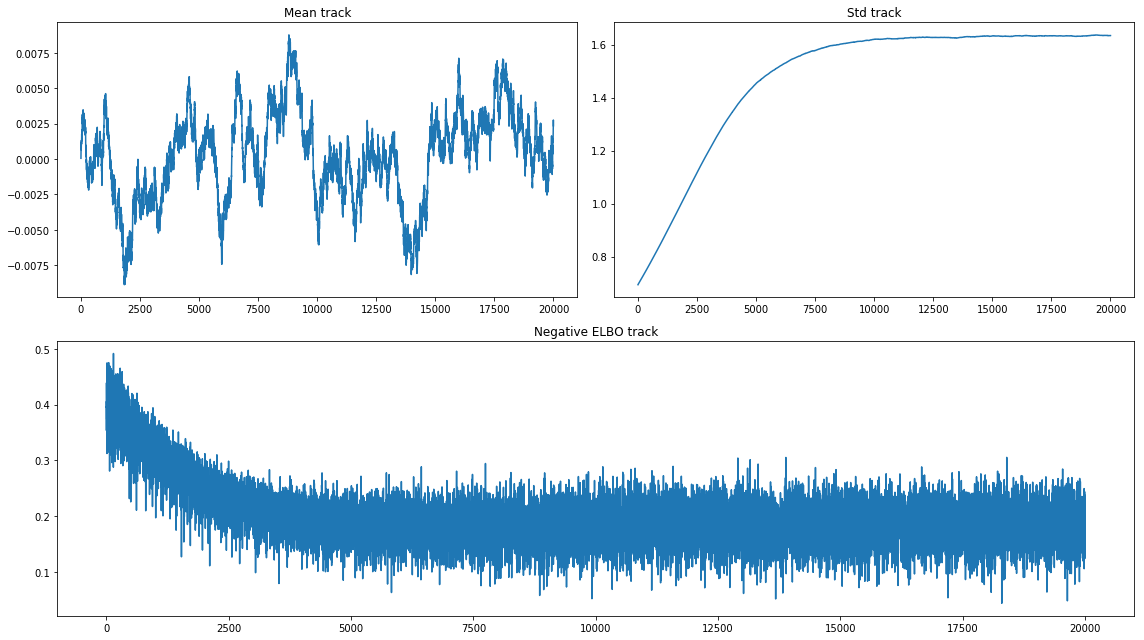

In [12]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track')
plt.tight_layout()

In [13]:
approx.mean.eval(), approx.std.eval()

(array([0.00234762]), array([1.63422561]))

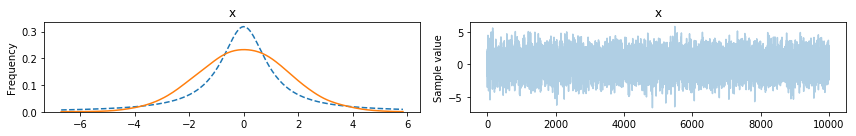

In [14]:
pm.traceplot(approx.sample(10000), priors=[pm.StudentT.dist(mu=0., sd=1., nu=1.)]);

In [15]:
approx.logp

mean

In [16]:
approx.logq

Elemwise{add,no_inplace}.0

In [95]:
import theano
from scipy import optimize
testval = np.concatenate([advi.approx.shared_params['mu'].get_value(),
                          advi.approx.shared_params['rho'].get_value()])
testval = np.array([5., 5.])

NEG_ELBO = theano.function([], advi.objective(1000))


def objective(point):
    mu = point[:len(point) // 2]
    rho = point[len(point) // 2:]
    advi.approx.shared_params['mu'].set_value(mu)
    advi.approx.shared_params['rho'].set_value(rho)
    return np.asscalar(NEG_ELBO())

In [112]:
optimize.fmin_bfgs?

In [111]:
r1 = optimize.fmin_cg(objective, testval, gtol=1e-50)

         Current function value: 1.255577
         Iterations: 0
         Function evaluations: 104
         Gradient evaluations: 23


In [106]:
r1[0], pm.distributions.dist_math.rho2sd(r1[1]).eval()

(4.999767643005451, array(5.00676538))